In [101]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# NYC Airbnbs-2019 veri kümesini yükleme
df = pd.read_csv('/content/drive/MyDrive/AI-ML/GlobalAIHub_Aygaz_Veri_Analizi_Bootcamp/Bootcamp_Projem/AB_NYC_2019.csv')
df = df[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

class AirbnbListing:
    def __init__(self, id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365):
        self.id = id
        self.name = name
        self.host_id = host_id
        self.host_name = host_name
        self.neighbourhood_group = neighbourhood_group
        self.neighbourhood = neighbourhood
        self.latitude = latitude
        self.longitude = longitude
        self.room_type = room_type
        self.price = price
        self.minimum_nights = minimum_nights
        self.number_of_reviews = number_of_reviews
        self.last_review = last_review
        self.reviews_per_month = reviews_per_month
        self.calculated_host_listings_count = calculated_host_listings_count
        self.availability_365 = availability_365

# Airbnb listeleri oluşturma
airbnb_listings = []
for index, row in df.iterrows():
    listing = AirbnbListing(row['id'], row['name'], row['host_id'], row['host_name'], row['neighbourhood_group'], row['neighbourhood'],
                            row['latitude'], row['longitude'], row['room_type'], row['price'], row['minimum_nights'], row['number_of_reviews'], row['last_review'],
                            row['reviews_per_month'], row['calculated_host_listings_count'], row['availability_365'])
    airbnb_listings.append(listing)

# Kullanıcılar oluşturma
class User:
    def __init__(self, id, name, interests):
        self.id = id
        self.name = name
        self.interests = interests

# Rastgele müşteri ve tercihleri oluşturma
users = []
interests_pool = ["sightseeing", "local_cuisine", "art", "history", "shopping", "beaches"]
for user_id in range(1, 101):
    random_name = "User " + str(user_id)
    random_interests = random.sample(interests_pool, random.randint(1, 5))
    user = User(user_id, random_name, random_interests)
    users.append(user)

# Ratings oluşturma (Rastgele puanlar)
ratings = {}
for user in users:
    user_ratings = {}
    for listing in airbnb_listings:
        user_ratings[listing.id] = random.randint(1, 5)  # 1 ila 5 arasında rastgele puanlar veriyoruz
    ratings[user.id] = user_ratings


def match_users_with_listings(users, airbnb_listings):
    matched_users_with_listings = {}

    for user in users:
        user_listings = []
        for listing in airbnb_listings:
            for interest in user.interests:
                if pd.notna(listing.name) and pd.notna(listing.neighbourhood_group):
                    if interest in listing.name or interest in listing.neighbourhood_group:
                        user_listings.append((listing, listing.neighbourhood_group))
                        break
        matched_users_with_listings[user] = user_listings

    return matched_users_with_listings



#user1 = User(1, "Alice", ["sightseeing", "local_cuisine"])
#user2 = User(2, "Bob", ["art", "history"])

#users = [user1, user2]

# İçeriğe dayalı konaklama önerisi
def content_based_recommendations(user, airbnb_listings):
    # Kullanıcının ilgi alanlarını tek bir metin olarak birleştirme
    user_interests_text = " ".join(user.interests)

    # TfidfVectorizer kullanarak metin vektörlerini oluşturma
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform([user_interests_text])

    # Benzerlik matrisini hesaplama
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Kullanıcının ilgi alanlarına en uygun olan listeleri sıralama
    similar_listings_indices = cosine_sim[0].argsort()[::-1][1:4]  # İlk öneri kullanıcı kendisi olacağından 1'den başlatılır
    recommended_listings = [(airbnb_listings[idx], airbnb_listings[idx].location) for idx in similar_listings_indices]

    return recommended_listings

# İşbirliğine dayalı filtreleme ile konaklama önerisi
def collaborative_filtering_recommendations(user, airbnb_listings, ratings):
    user_ratings = ratings.get(user.id, [])
    user_listings = [listing for listing in airbnb_listings if listing.id in user_ratings]

    # Tüm kullanıcıların verdiği puanlar
    all_ratings = {user.id: ratings.get(user.id, {}) for user in users}

    # Kullanıcı benzerlik matrisini hesaplama (Cosine Similarity)
    similarity_matrix = np.zeros((len(users), len(users)))
    for i, user1 in enumerate(users):
        for j, user2 in enumerate(users):
            user1_ratings = np.array([all_ratings[user1.id].get(listing.id, 0) for listing in user_listings])
            user2_ratings = np.array([all_ratings[user2.id].get(listing.id, 0) for listing in user_listings])

            # Kontrol ekleme: Her iki kullanıcının da en az bir değerlendirmesi varsa
            if np.any(user1_ratings) and np.any(user2_ratings):
                similarity_matrix[i, j] = np.dot(user1_ratings, user2_ratings) / (np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings))

    # Kullanıcıya benzer kullanıcıları bulma
    similar_users_indices = similarity_matrix[user.id - 1].argsort()[::-1][1:4]
    similar_users = [users[idx] for idx in similar_users_indices]

    # Benzer kullanıcıların konaklama listelerinden yeni öneriler
    recommended_listings = []
    for similar_user in similar_users:
        for listing in airbnb_listings:
            if listing.id not in ratings[user.id] and listing.id in ratings[similar_user.id]:
                recommended_listings.append((listing, listing.location))

    return recommended_listings

# Proje kullanıcı arayüzü (Örnek olarak kullanıcı eşleşmelerini ve konaklama önerilerini gösteriyor)
def main():
    matched_users_with_listings = match_users_with_listings(users, airbnb_listings)

    for user, listings in matched_users_with_listings.items():
        print(f"\n{user.name}'a önerilen konaklamalar:")
        for listing, location in listings:
            print(f"- Konaklama ID: {listing.id}, Yer: {location}, Fiyat: ${listing.price}, Ev Sahibi: {listing.host_name}")



        # İçeriğe dayalı konaklama önerileri
        content_based_recs = content_based_recommendations(user, airbnb_listings)
        print(f"\n{user.name}'a içeriğe dayalı öneriler:")
        for listing, location in content_based_recs:
            print(f"- Konaklama ID: {listing.id}, Yer: {location}, Fiyat: ${listing.price}, Ev Sahibi: {listing.host}")

        # İşbirliğine dayalı filtreleme ile konaklama önerileri
        #collaborative_recs = collaborative_filtering_recommendations(user, airbnb_listings,ratings=1) önceki
        collaborative_recs = collaborative_filtering_recommendations(user, airbnb_listings, ratings)

        print(f"\n{user.name}'a işbirliğine dayalı öneriler:")
        for listing, location in collaborative_recs:
            print(f"- Konaklama ID: {listing.id}, Yer: {location}, Fiyat: ${listing.price}, Ev Sahibi: {listing.host}")

        # Isı Haritası görselleştirmesi için liste oluşturma
        prices = [listing.price for listing, location in collaborative_recs]
        locations = [location for listing, location in collaborative_recs]

        # Dağılım grafiği (Histogram) - Konaklama birimlerinin fiyat dağılımı
        prices = [listing.price for listing in airbnb_listings]
        plt.hist(prices, bins=30, color='skyblue', edgecolor='black')
        plt.xlabel('Fiyat ($)')
        plt.ylabel('Frekans')
        plt.title('Konaklama Birimlerinin Fiyat Dağılımı')
        plt.show()

        plt.show()

if __name__ == "__main__":
    main()


Output hidden; open in https://colab.research.google.com to view.

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype

In [103]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# NYC Airbnbs-2019 veri kümesini yükleme
df = pd.read_csv('/content/drive/MyDrive/AI-ML/GlobalAIHub_Aygaz_Veri_Analizi_Bootcamp/Bootcamp_Projem/AB_NYC_2019.csv')
df = df[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]


In [104]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [106]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [107]:
df["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [108]:
df["room_type"].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [109]:
df["room_type"].head()

0       Private room
1    Entire home/apt
2       Private room
3    Entire home/apt
4    Entire home/apt
Name: room_type, dtype: object

Text(0.5, 1.0, 'Class Frequencies of Room Types Variables')

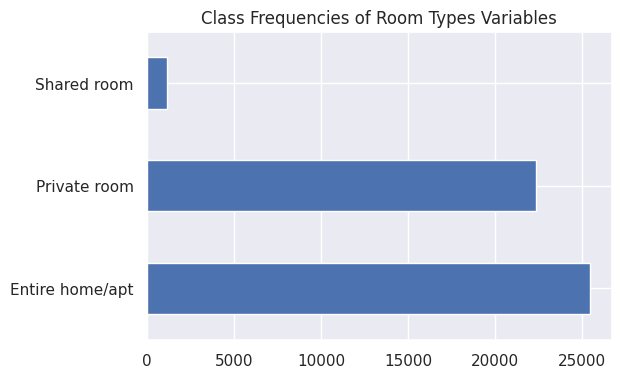

In [110]:
df["room_type"].value_counts().plot.barh().set_title("Class Frequencies of Room Types Variables")

Text(0.5, 1.0, 'Class Frequencies of Room Types Variables')

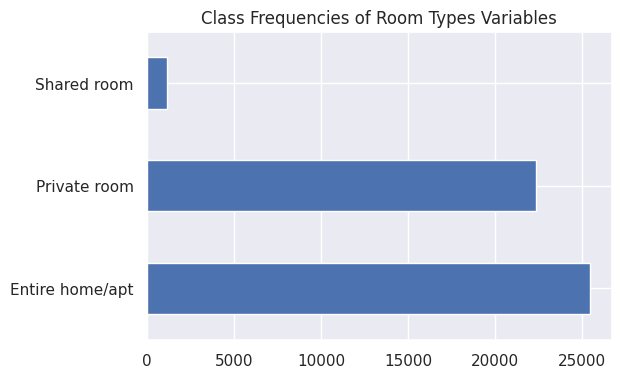

In [111]:
df["room_type"].value_counts().plot.barh().set_title("Class Frequencies of Room Types Variables")

Text(0.5, 1.0, 'Class Frequencies Number of Reviews Variables')

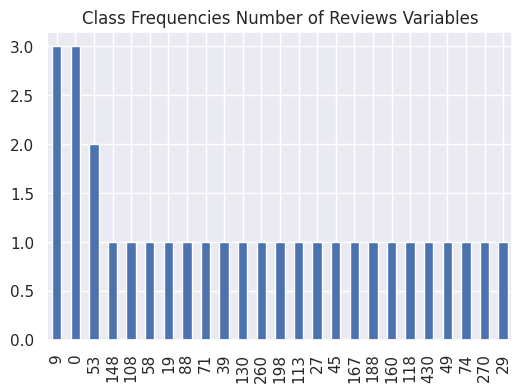

In [112]:
df["number_of_reviews"][:30].value_counts().plot.bar().set_title("Class Frequencies Number of Reviews Variables")

In [113]:
df["room_type"].index

RangeIndex(start=0, stop=48895, step=1)

Text(0.5, 1.0, 'Room Type Density')

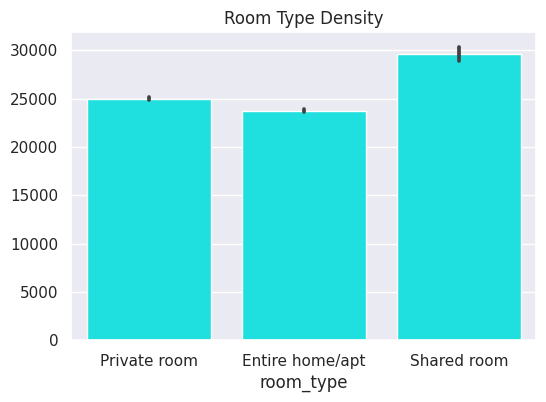

In [114]:
sns.barplot(x="room_type", y=df["room_type"].index, data=df, color="cyan").set_title("Room Type Density")

Text(0.5, 1.0, 'Room Type - NumberOfReviews - Price')

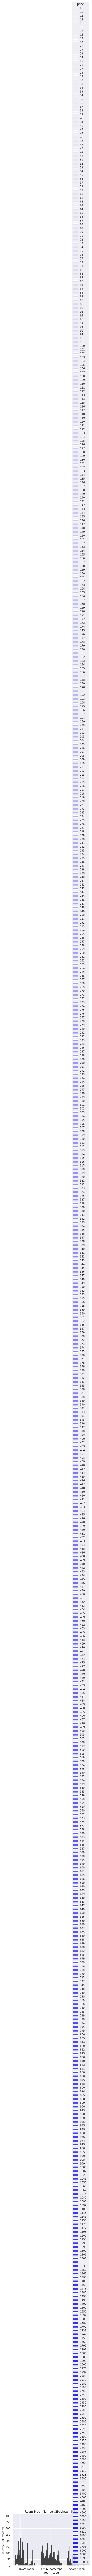

In [115]:
sns.barplot(x="room_type", y="number_of_reviews", hue="price", data=df, color="blue")
plt.title("Room Type - NumberOfReviews - Price")

Text(0.5, 1.0, 'Room Type - Price - NumberOfReviews')

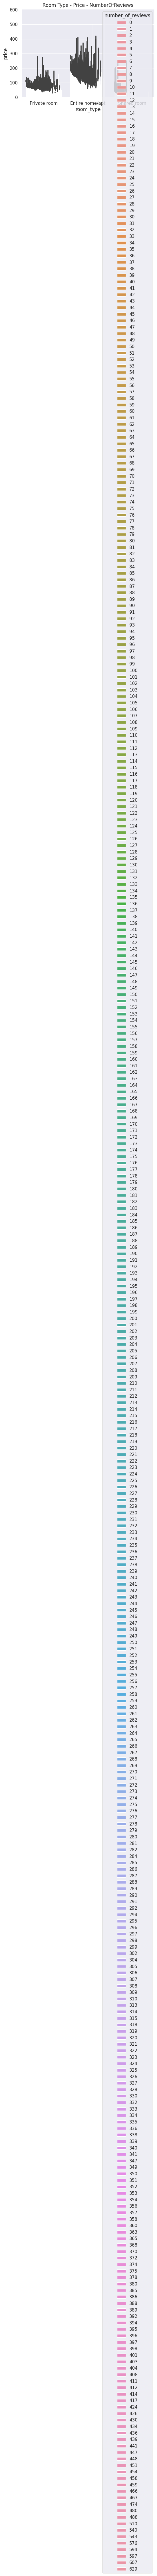

In [116]:
sns.barplot(x="room_type",
            y="price",
            hue="number_of_reviews",
            data=df)
plt.title("Room Type - Price - NumberOfReviews")

Text(0.5, 1.0, 'Room Type - Price - NumberOfReviews')

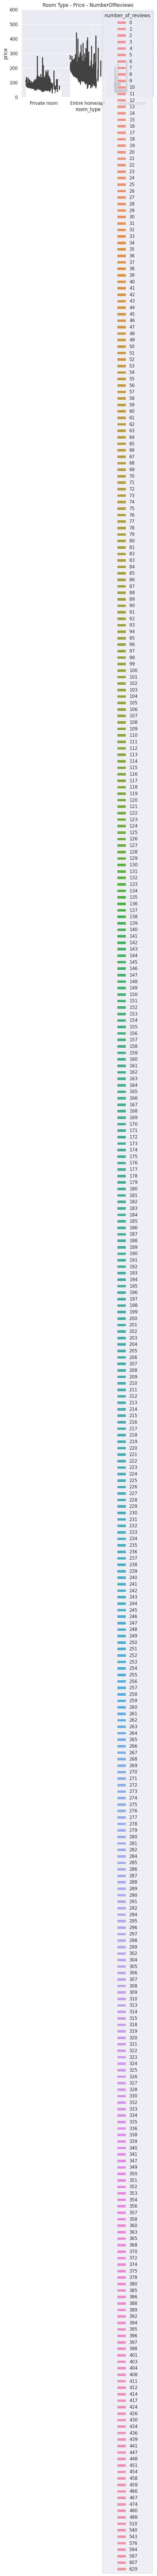

In [117]:
sns.barplot(x="room_type",
            y="price",
            hue="number_of_reviews",
            data=df)
plt.title("Room Type - Price - NumberOfReviews")

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

<ipython-input-119-57a524987454>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("room_type").sum().plot.pie(y="price", autopct="%.1f%%", ylabel="", legend=False, figsize=(5,5))


<Axes: >

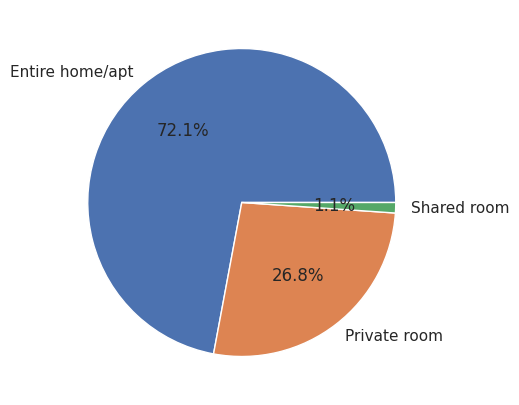

In [119]:
df.groupby("room_type").sum().plot.pie(y="price", autopct="%.1f%%", ylabel="", legend=False, figsize=(5,5))

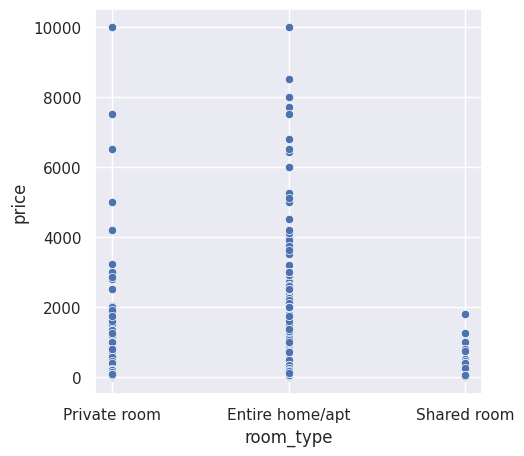

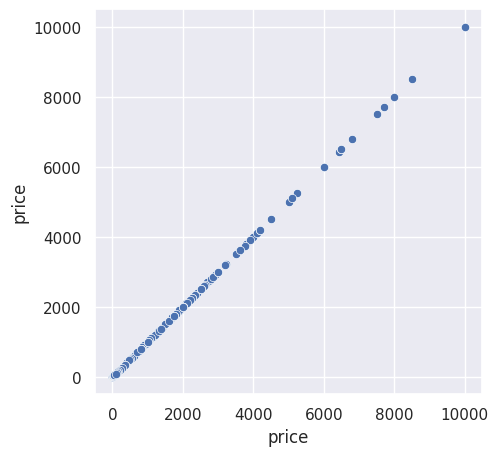

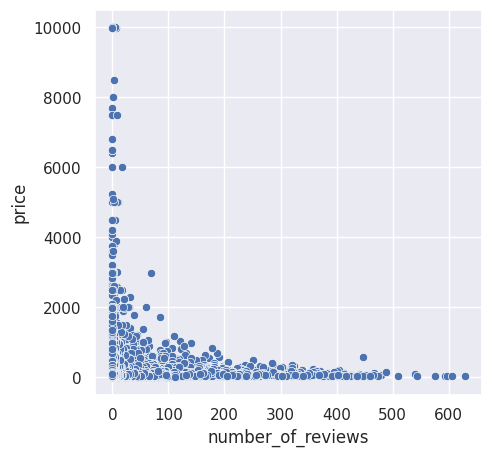

In [120]:
cols = ["room_type", "price", "number_of_reviews"]

for col in cols:
  plt.figure(figsize=(5,5))
  sns.scatterplot(x=col, y="price", data=df)

<Axes: xlabel='price', ylabel='Count'>

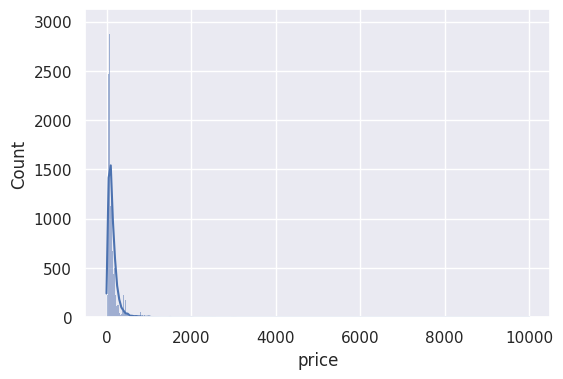

In [121]:
sns.histplot(df["price"], kde=True) # bins= auto

<Axes: xlabel='price', ylabel='Count'>

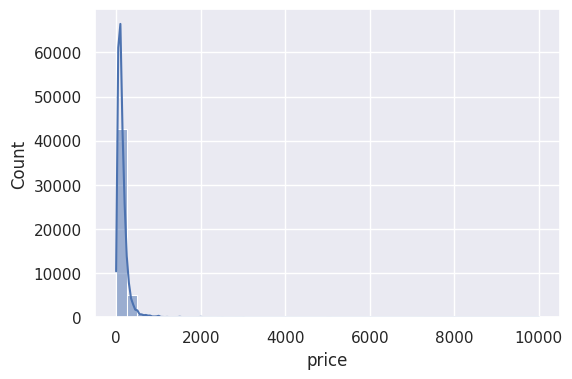

In [122]:
sns.histplot(df["price"], kde=True, bins=40)

<Axes: xlabel='price', ylabel='Density'>

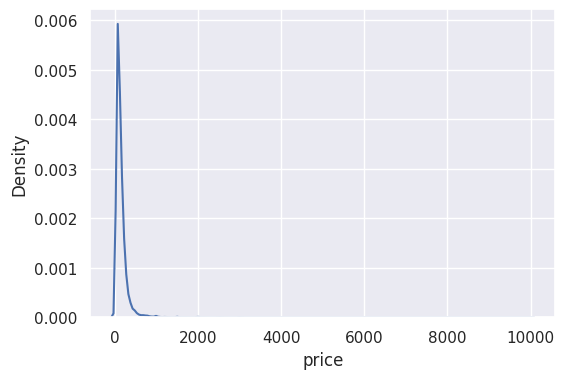

In [123]:
sns.kdeplot(df["price"])

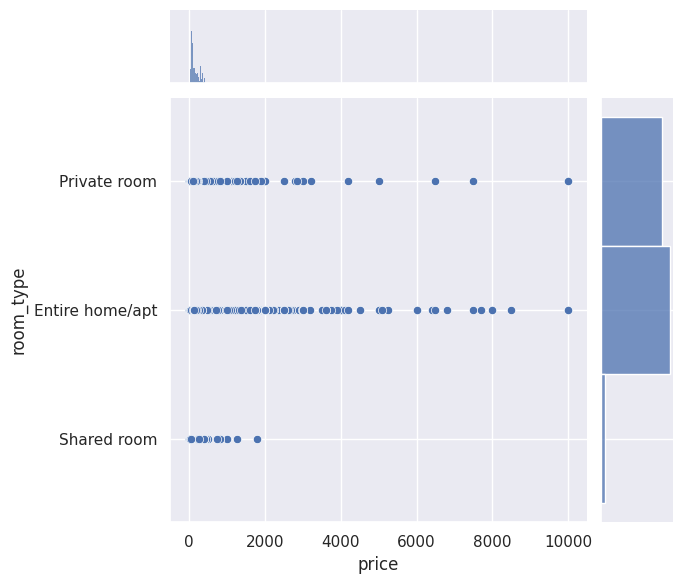

In [124]:
sns.jointplot(x="price", y=df["room_type"], data=df)

Text(0.5, 1.0, 'Room Type - Price')

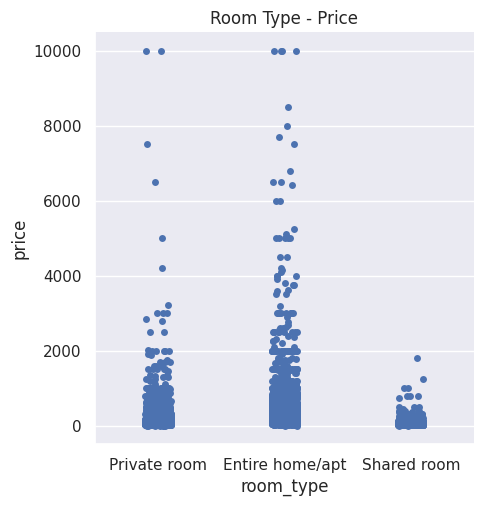

In [125]:
sns.catplot(x="room_type", y="price", data=df)
plt.title("Room Type - Price")

Text(0.5, 1.0, 'Room Type - Price')

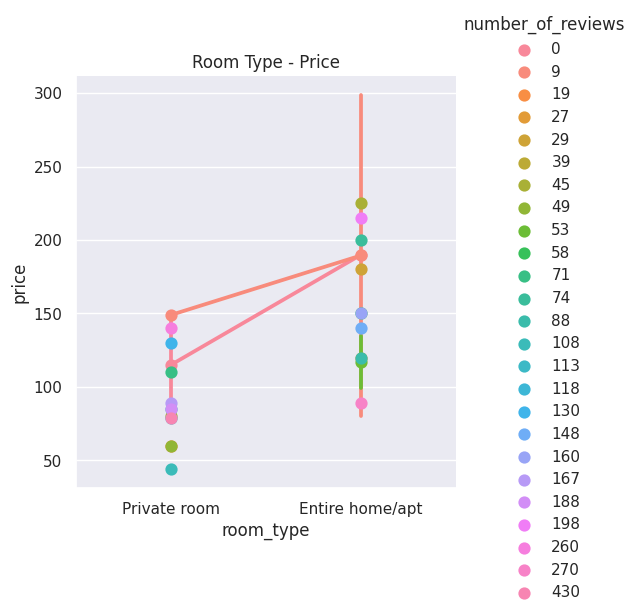

In [126]:
sns.catplot(x="room_type", y="price", hue="number_of_reviews", kind="point", data=df[:30])
plt.title("Room Type - Price")

<ipython-input-127-6e1ef0e267b4>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["price"], shade=True)


<Axes: xlabel='price', ylabel='Density'>

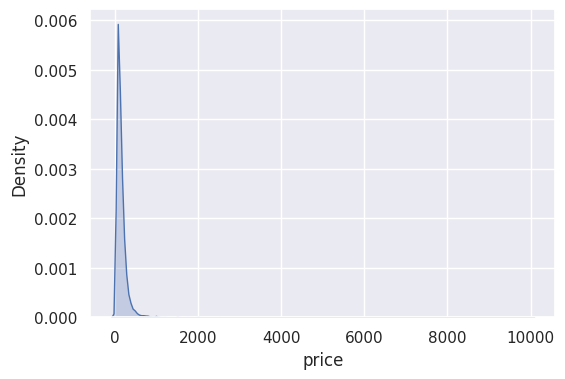

In [127]:
sns.kdeplot(df["price"], shade=True)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


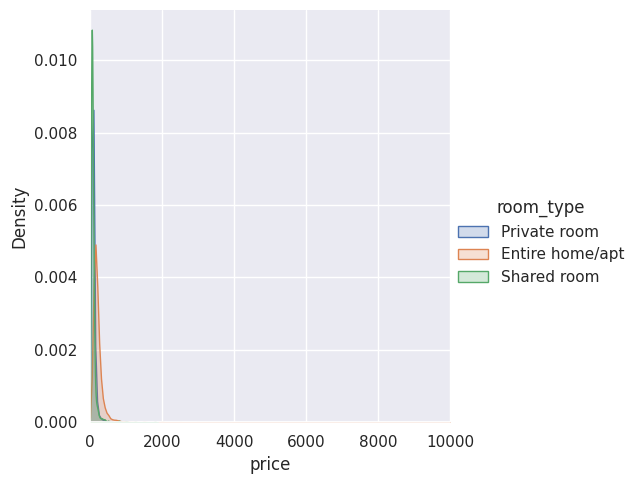

In [128]:
(sns.FacetGrid(df, hue="room_type", height=5, xlim=(0, 10000)).map(sns.kdeplot, "price", shade=True).add_legend())

<ipython-input-129-f66c84eb23f7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[:5].corr(), annot=True, fmt=".2f");


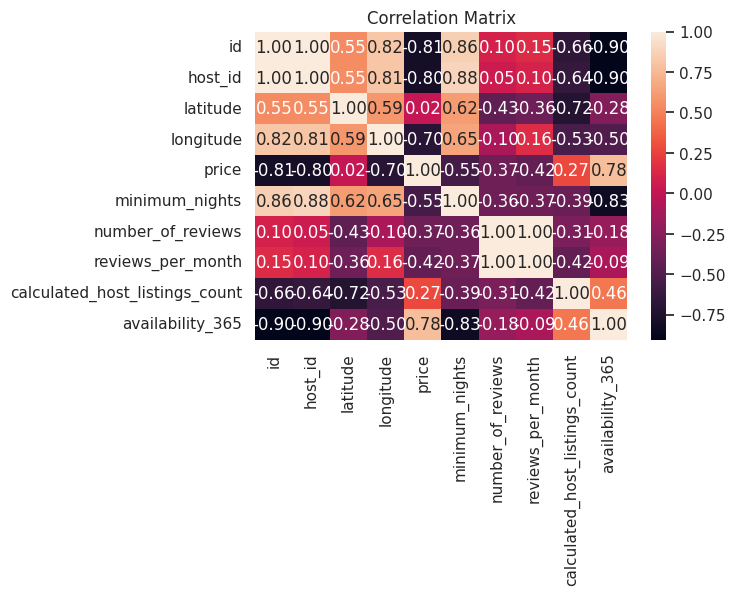

In [129]:
plt.title("Correlation Matrix")
sns.heatmap(df[:5].corr(), annot=True, fmt=".2f");